# Potencial de cartera con tasas bajas

Acá lo que queremos estudiar son los créditos que tienen tasas abajo de 14%. La hipótesis es que son créditos viejos. Queremos ver qué se les puede ofrecer (podría ser un recrédito porque seguramente ya tienen el 15%)

In [1]:
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(r"C:\Users\mariajose_chinchilla\Documents\GitHub\proyectos_varios\codigos")
from utils import calcular_cuota, ingresos_financieros, ingreso_fin_entre_fechas

In [2]:
mes_simulacion = 11

In [ ]:
def leer_sql(lectura: bool): 
    if lectura:
        conn = pyodbc.connect('DRIVER={SQL Server};'
                                'SERVER=BTBIDB-VM;'
                                'DATABASE=LNDDW;'
                                'Trusted_Connection=yes;')
        # Conectarse a datos de cambio de tasas
        with open (r"C:\Users\mariajose_chinchilla\Desktop\Queries\cartera activa.sql", "r") as q1:
            query1 = q1.read()

        # Leer datos con pandas
        cartera = pd.read_sql_query(query1, conn)

    elif not lectura:
        cartera = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Noviembre\cartera_octubre.csv")

    return cartera
    

In [5]:
cartera = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Noviembre\cartera_octubre.csv",
                       sep=";"
                      )
# cartera = cartera[cartera["RCI"] > 0]
dpis = pd.read_csv("../../db/ingresos.csv")
cartera = cartera[cartera["PATRONO"] != "Ditca"]
cartera.drop_duplicates(subset="NO_CREDITO", inplace=True)

In [6]:
cartera["DPI"] = cartera["DPI"].astype("str")
dpis["DPI"] = cartera["DPI"].astype("str")
# cartera = pd.merge(cartera, dpis, on="DPI", how="left")


In [ ]:
cartera.rename(columns={"RCI_x": "RCI"}, inplace=True)

In [ ]:
cartera["TIPO_PAGO"].unique()

In [7]:
remesa = cartera[(cartera["TIPO_PAGO"] == "REMESA")]

In [8]:
remesa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200633 entries, 0 to 203505
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FEC_SALDO             200633 non-null  object 
 1   CODIGO_CLIENTE        200633 non-null  int64  
 2   DPI                   200633 non-null  object 
 3   NO_CREDITO            200633 non-null  int64  
 4   FECHA_APERTURA        200633 non-null  object 
 5   FECHA_CANCELACION     200633 non-null  object 
 6   FECHA_VENCIMIENTO     200633 non-null  object 
 7   COD_PATRONO           200633 non-null  int64  
 8   PATRONO               200633 non-null  object 
 9   COD_SEGMENTO          200633 non-null  object 
 10  RCI                   200499 non-null  float64
 11  SEGMENTO              191567 non-null  object 
 12  PLAZO                 200633 non-null  float64
 13  SALDO                 200633 non-null  float64
 14  MONTO_DESEMBOLSADO    200633 non-null  float64
 15  DESEM

In [ ]:
remesa.describe()

In [ ]:
remesa["CREDITO_CUMPLE_15"].value_counts().reset_index(name="Conteo")

In [ ]:
remesa_nivel_cliente = remesa.groupby(by="CODIGO_CLIENTE")["CREDITO_CUMPLE_15"].min().reset_index(name="Cliente cumple 15%")
remesa_nivel_cliente["Cliente cumple 15%"].value_counts()

In [ ]:
remesa["PORCENTAJE PAGADO"] = 1 - remesa["SALDO"] / remesa["MONTO_DESEMBOLSADO"]
remesa_temp = remesa.groupby(by="PATRONO").agg(
        CLIENTES=("PATRONO", "size"), 
        SALDO_INTERNO=("SALDO", "sum"),
        SALDO_PROMEDIO=("SALDO", "mean"),
        RCI_PROMEDIO=("RCI", "mean")).reset_index().sort_values(by="SALDO_INTERNO", ascending=False)

remesa_temp["SALDO_INTERNO"] = remesa_temp["SALDO_INTERNO"].astype("int64")
remesa_temp.head(5)

In [ ]:
# base = remesa[remesa["CLIENTE_CUMPLE_15"] == 1]
# a = sum(base["MONTO_DESEMBOLSADO"] * base["TASA"])
# b = base["MONTO_DESEMBOLSADO"].sum()
# a / b

In [ ]:
remesa.columns

## Gráficas

In [12]:
import matplotlib.pyplot as plt
remesa = remesa[remesa["RCI"] > 0]

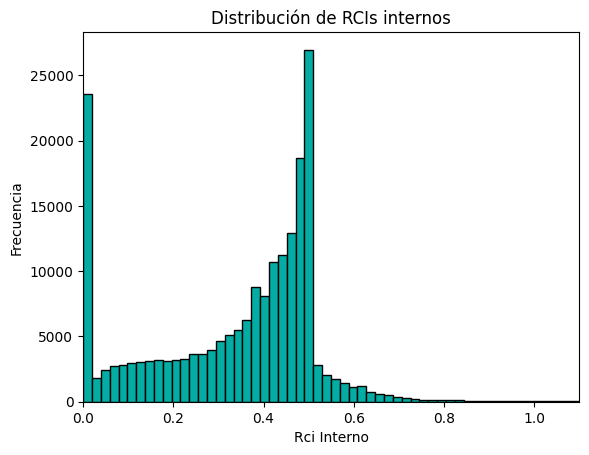

In [16]:
plt.plot(figsize=(10,6))
plt.hist(cartera["RCI"], bins=2000, edgecolor="black", color="#04aca4")
plt.xlabel("Rci Interno")
plt.ylabel("Frecuencia")
plt.xlim([0,1.1])
plt.title("Distribución de RCIs internos")
plt.show()

In [ ]:
frecuencias_15 = remesa_nivel_cliente["Cliente cumple 15%"].value_counts().reset_index(name="Frecuencia")
# Crear diagrama de barras
plt.bar(frecuencias_15['Cliente cumple 15%'], frecuencias_15['Frecuencia'], color=['#e2056b', '#04aca4'])

# Etiquetas y título
plt.title('Frecuencia de cumplimiento del 15% por cliente')
plt.xticks(frecuencias_15['Cliente cumple 15%'])  # Mostrar los valores correctos de las columnas en el eje X
plt.xlabel('Cliente cumple 15%')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


## Propuesta generalizada

### Habilitados por 15%

In [ ]:
import numpy as np
# Función que aumenta en un 1% la TPP del cliente
def tasa_habilitados(montos: list, k: float, tasas: list) -> float:
    a1 = np.array(tasas)
    a2 = np.array(montos)
    tpp_cliente = np.dot(a1, a2) / sum(montos)
    n = (tpp_cliente + 1) * (sum(montos) * (1 + k)) - np.dot(a1, a2)
    d = k * sum(montos)
    return n / d

### Inhabilitados por 15%

In [ ]:
def tasa_inhabilitados(montos: list, tasas: list) -> float:
    a1 = np.array(tasas)
    a2 = np.array(montos)
    tpp_cliente = np.dot(a1, a2) / sum(montos)
    alpha = (0.08 + 0.0025) / (1-0.146)
    reservas = 0.45 * 0.056
    return max(tpp_cliente + 2, alpha * 100 + reservas * 100 + 1.25)

### Tasa final

In [ ]:
# def tasa_final(cumple_15, montos, tasas, k):
#     if cumple_15 == 1:
#         tasa = tasa_habilitados(montos, k, tasas)
#     elif cumple_15 == 0:
#         tasa = tasa_inhabilitados(montos, tasas)
#     return tasa

def tasa_final(cumple_15, montos, tasas, k):
    if cumple_15 == 1:
        a = np.array(tasas)
        b = np.array(montos)
        tpp = np.dot(a, b) / sum(montos)
        tasa = tpp + 1
    elif cumple_15 == 0:
        tasa = tasa_inhabilitados(montos, tasas)
    return tasa


## Impactos de escenario

In [ ]:
cols = ["CODIGO_CLIENTE", "DPI", "RCI", "SALDO", "MONTO_DESEMBOLSADO", 
        "DESEMBOLSO_NETO", "TASA", "FACTOR_TASA", "CREDITO_CUMPLE_15",
        "DEUDA_INTERNA"]

remesa_temp = remesa.groupby(by="CODIGO_CLIENTE").agg(
            CLIENTE_CUMPLE_15=("CREDITO_CUMPLE_15", "min"),
            SALDO_EN_TASAS_BAJAS=("SALDO", "sum"),
            DESEMBOLSADO_EN_TASAS_BAJAS=("MONTO_DESEMBOLSADO", "sum"),
            PLAZO_OFERTA=("PLAZO", "max"),
            TASAS=("TASA", list),
            MONTOS=("MONTO_DESEMBOLSADO", list)
)
remesa = pd.merge(remesa, remesa_temp, on="CODIGO_CLIENTE")
remesa.head(3)

In [ ]:
nivel_cliente = remesa.drop_duplicates(subset="CODIGO_CLIENTE")
nivel_cliente["MONTO OFERTA"] = 1.25 * nivel_cliente["DESEMBOLSADO_EN_TASAS_BAJAS"]
nivel_cliente["TASA OFERTA"] = nivel_cliente.apply(lambda x: tasa_final(x["CLIENTE_CUMPLE_15"], 
                                                                        x["MONTOS"], x["TASAS"], 1.25), axis=1)

In [ ]:
nivel_cliente["NUEVA CUOTA"] = nivel_cliente.apply(lambda x: calcular_cuota(x["MONTO OFERTA"],
                                                                           x["TASA OFERTA"]/1200,
                                                                           x["PLAZO_OFERTA"]), axis=1)

nivel_cliente["NUEVO RCI"] = nivel_cliente["RCI"] * 100 + nivel_cliente["NUEVA CUOTA"] / 5000

In [ ]:
nivel_cliente["INGRESOS FIN DE AÑO"] = nivel_cliente.apply(lambda x: ingresos_financieros(x["MONTO OFERTA"],
                                                                                          x["TASA OFERTA"]/1200,
                                                                                          x["PLAZO_OFERTA"], 12 - mes_simulacion + 1),
                                                                                            axis=1)

nivel_cliente["INGRESOS 12 MESES"] = nivel_cliente.apply(lambda x: ingresos_financieros(x["MONTO OFERTA"],
                                                                                          x["TASA OFERTA"]/1200,
                                                                                          x["PLAZO_OFERTA"], 12),
                                                                                            axis=1)

In [ ]:
alpha = (0.08 + 0.0025) / ( 1- 0.146)
nivel_cliente["PASIVOS FIN DE AÑO"] = nivel_cliente.apply(lambda x: ingresos_financieros(x["MONTO OFERTA"],
                                                                                          alpha/12,
                                                                                          x["PLAZO_OFERTA"], 12 - mes_simulacion + 1),
                                                                                            axis=1)

nivel_cliente["PASIVOS 12 MESES"] = nivel_cliente.apply(lambda x: ingresos_financieros(x["MONTO OFERTA"],
                                                                                          alpha/12,
                                                                                          x["PLAZO_OFERTA"], 12),
                                                                                            axis=1)


In [ ]:
nivel_cliente["RESERVAS"] = (1 - nivel_cliente["CLIENTE_CUMPLE_15"]) * 0.45 * 0.086 * nivel_cliente["MONTO OFERTA"]

## Resumen de impactos

In [ ]:
viables = nivel_cliente[(nivel_cliente["NUEVO RCI"] <= 60)]
habilitados = viables[viables["CLIENTE_CUMPLE_15"] == 1]
dic = {"Ingresos fin de año: ": habilitados["INGRESOS 12 MESES"].sum() / 10**6,
       "Margen fin de año: ": (habilitados["INGRESOS 12 MESES"].sum() - habilitados["PASIVOS 12 MESES"].sum()) / 10**6,
       "Clientes viables: ": len(habilitados),
       "Potencial de desembolso: ": habilitados["MONTO OFERTA"].sum() / 10**6,
       "TPP ensayo: ": sum(habilitados["MONTO OFERTA"] * habilitados["TASA OFERTA"]) / sum(habilitados["MONTO OFERTA"])}

for nombre, valor in dic.items():
    print(nombre, valor)

In [ ]:
### A 12 MESES
inhabilitados = viables[viables["CLIENTE_CUMPLE_15"] == 0]
dic = {"Ingresos 12 meses: ": inhabilitados["INGRESOS FIN DE AÑO"].sum() / 10**6,
       "Margen 12 meses: ": (inhabilitados["INGRESOS FIN DE AÑO"].sum() - inhabilitados["PASIVOS FIN DE AÑO"].sum() - inhabilitados["RESERVAS"].sum()) / 10**6,
        "Reservas por reestructura: ": inhabilitados["RESERVAS"].sum() / 10**6, 
       "Clientes viables: ": len(inhabilitados),
       "Potencial de desembolso: ": inhabilitados["MONTO OFERTA"].sum() / 10**6,
       "TPP ensayo: ": sum(inhabilitados["MONTO OFERTA"] * inhabilitados["TASA OFERTA"]) / sum(inhabilitados["MONTO OFERTA"])}

for nombre, valor in dic.items():
    print(nombre, valor)
    

In [ ]:
plt.plot(figsize=(10,6))
plt.hist(viables["NUEVO RCI"], bins=30, edgecolor="black", color="#e2056b")
plt.xlabel("Nuevo Rci Interno")
plt.ylabel("Frecuencia")
plt.xlim([0,60])
plt.title("Distribución de RCIs internos luego de la iniciativa")
plt.show()

In [ ]:
sum(viables["TASA OFERTA"] * viables["MONTO OFERTA"]) / sum(viables["MONTO OFERTA"])

In [ ]:
habilitados.to_csv("../../db/Salidas/Habilitados_tasas_bajas.csv")